In [1]:
import ee
import geemap

In [2]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from skimage import io
import numpy as np
import ee
import geemap
import logging
import multiprocessing
import os
import requests
import shutil
# from retry import retry
from datetime import datetime
import matplotlib.pyplot as plt

from collections import namedtuple

In [3]:
from utils.utils import *
from utils.ee_utils import *

4/1AfgeXvvmWF-_z0qOvwsZK597gUnHMOdSTjpY6CStI-buWxqNvRlGoRU19og

In [4]:
Map = geemap.Map()

In [5]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

# A Function to retrive S1 and S2

has two inputs:
*   date
*   roi


Returns:
*   s1
*   s2 image




In [6]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

---

### add to current time
used [this doc ](https://bobbyhadz.com/blog/python-add-months-to-date#:~:text=Use%20the%20relativedelta%20class%20from,with%20different%20numbers%20of%20days.)

we use this function to to expand the time span we are searching for `S2` images, if the S2 mosaic was not coplete in the month we want, it increases the span.

In [7]:
date_time_obj = datetime.strptime('2020-01-02', '%Y-%m-%d')
new_date_time_obj= date_time_obj + relativedelta(months=+3)
print(new_date_time_obj)
print(new_date_time_obj.strftime('%Y-%m-%d'))
print(type(new_date_time_obj.strftime('%Y-%m-%d')))

2020-04-02 00:00:00
2020-04-02
<class 'str'>


### the idea behind buffering
so s2 images an area evry five days, so the sampling rate is 5 days, so if we find an snowy s2 image we assume that the whole five days which is 2 days before and 2 days after, are snowy, we add all these days into a list, as snowy days to later check s1 images and remove those that have the same date as this list.

# OSCD Dataset ROIs

## aguasclaras

In [29]:
from rois import ROIS
rois = ROIS()
roi = rois.bercy

In [30]:
features = geemap.fishnet(roi, rows=2, cols=2, delta=0.1)
#features = geemap.fishnet(roi, h_interval=0.05, v_interval=0.05)

In [31]:
Map = geemap.Map(zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayer(roi)

# Map.addLayer(abudhabi,{'color': 'fc0303'})
# Map.addLayer(aguasclaras,{'color': 'fc5e03'})
# Map.addLayer(beihai,{'color': 'fcad03'})
# Map.addLayer(beirut,{'color': 'fce303'})
# Map.addLayer(bercy,{'color': 'c6fc03'})
# Map.addLayer(bordeaux,{'color': '7bfc03'})
# Map.addLayer(brasilia,{'color': '35fc03'})
# Map.addLayer(chongqing,{'color': '03fc80'})
# Map.addLayer(cupertino,{'color': '03fcc6'})
# Map.addLayer(dubai,{'color': '03fce3'})
# Map.addLayer(hongkong,{'color': '03dffc'})
# Map.addLayer(lasvegas,{'color': '0394fc'})
# Map.addLayer(milano,{'color': '0362fc'})
# Map.addLayer(montpellier,{'color': '0318fc'})
# Map.addLayer(mumbai,{'color': '5a03fc'})
# Map.addLayer(nantes,{'color': '9803fc'})
# Map.addLayer(norcia,{'color': 'c203fc'})
# Map.addLayer(paris,{'color': 'fc03f4'})
# Map.addLayer(pisa,{'color': 'fc03ce'})
# Map.addLayer(rennes,{'color': 'fc03a5'})
# Map.addLayer(rio,{'color': 'fc036f'})
# Map.addLayer(saclay_e,{'color': 'fc0345'})
# Map.addLayer(saclay_w,{'color': 'fc032d'})
# Map.addLayer(valencia,{'color': 'fc0303'})

# Map.addLayer(features, {}, 'Grids')
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [34]:
s2_test_col = ee.ImageCollection('COPERNICUS/S2_SR') \
                    .filterDate('2021-05-17', '2021-05-19') \
                    .filterBounds(roi)
                    
sen2_print(s2_test_col)
s2_test_img = s2_test_col.first()

scl = s2_test_img.select('SCL')
mask = scl.eq(11)

Map = geemap.Map()
Map.addLayer(s2_test_img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image', True)
Map.addLayer(mask.updateMask(mask), {'palette': 'blue'}, 'Water Mask')
Map.centerObject(roi, zoom=10)
Map.addLayerControl()
Map



system:time_start---------> ['2021-05-18']
roi_cloud_cover-----------> []
CLOUDY_PIXEL_PERCENTAGE---> [70.48862]
CLOUD_SHADOW_PERCENTAGE---> [0.703129]
VEGETATION_PERCENTAGE-----> [12.594715]
NOT_VEGETATED_PERCENTAGE--> [1.311284]
CLOUD_COVERAGE_ASSESSMENT-> [70.48862]
GENERATION_TIME-----------> [1621347252000]
SENSING_ORBIT_NUMBER------> [94]
NODATA_PIXEL_PERCENTAGE---> [26.389542]
DATATAKE_TYPE-------------> ['INS-NOBS']
SENSING_ORBIT_NUMBER------> [94]
SNOW_ICE_PERCENTAGE-------> [9.749825]
THIN_CIRRUS_PERCENTAGE----> [2.360785]
WATER_PERCENTAGE----------> [0.127259]
system:band_names---------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]


Map(center=[48.843641547684896, 2.380256652833762], controls=(WidgetControl(options=['position', 'transparent_…

In [17]:
# 'ASCENDING'
# 'DESCENDING'
s2_col,s1_col = s1s2(roi,date = ('2021-07-15', '2021-08-15'),priority_path = 'DESCENDING',max_cloud = 100,max_snow = 100,month_span = 1,retry_days=0)
# s2_col,s1_col_desc = s1s2(roi,date = ('2020-08-10', '2020-09-20'),priority_path = 'DESCENDING',max_cloud = 5)

◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2021-07-21
final date range:  2021-06-21 2021-08-21
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 93.96914404374861 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
collection size before removing snowy dates:  20
collection size after removing snowy dates:  20
◍Collection Found!


In [18]:
sen2_print(s2_col)

system:time_start---------> ['2021-07-19', '2021-07-22']
roi_cloud_cover-----------> [1.7293406458505447, 0.02405433293187481]
CLOUDY_PIXEL_PERCENTAGE---> [2.355076, 0.408007]
CLOUD_SHADOW_PERCENTAGE---> [0.07702, 0.250338]
VEGETATION_PERCENTAGE-----> [60.976559, 59.382445]
NOT_VEGETATED_PERCENTAGE--> [35.378841, 38.356686]
CLOUD_COVERAGE_ASSESSMENT-> [2.355076, 0.408007]
GENERATION_TIME-----------> [1626888199000, 1626958595000]
SENSING_ORBIT_NUMBER------> [51, 94]
NODATA_PIXEL_PERCENTAGE---> [5.6e-05, 26.77215]
DATATAKE_TYPE-------------> ['INS-NOBS', 'INS-NOBS']
SENSING_ORBIT_NUMBER------> [51, 94]
SNOW_ICE_PERCENTAGE-------> [5.6e-05, 3.6e-05]
THIN_CIRRUS_PERCENTAGE----> [2.076487, 0.001658]
WATER_PERCENTAGE----------> [0.497517, 0.560424]
system:band_names---------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7

In [20]:
sen1_print(s1_col.sort('system:time_start')) #.filter(ee.Filter.eq('relativeOrbitNumber_start', 30))

system:time_start---------------> ['2021-06-25', '2021-06-26', '2021-07-01', '2021-07-02', '2021-07-07', '2021-07-08', '2021-07-13', '2021-07-14', '2021-07-19', '2021-07-20', '2021-07-25', '2021-07-26', '2021-07-31', '2021-08-01', '2021-08-06', '2021-08-07', '2021-08-12', '2021-08-13', '2021-08-18', '2021-08-19']
orbitProperties_pass------------> ['DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING']
resolution----------------------> ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
resolution_meters---------------> [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
platform_number-----------------> ['B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'A', 'B', 'B', 

In [31]:
vis_params_s2 = {
  'min': 0.04,
  'max': 0.4,
  'bands': ['B4', 'B3', 'B2'],
}

# un comment this for Band 8 to be added to the map so you can check the correlation between NIR and radar backscatter

# vis_params_s2 = {
#   'min': 0.04,
#   'max': 0.4,
#   'bands': ['B8'],
# }

vis_params_s1_dark = {
    'min': -18,
    'max': -2,
    'bands': ['VV_db']
}

# vis params for dense urban structure, comment if images is too dark. (so the above one gets applied)
vis_params_s1_bright = {
    'min': -10,
    'max': 10,
    'bands': ['VV_db']
}

## To Linear and back again!
as was said in the `Woodhouse pg. 324` we cannot averasge over `db` values.
so we convert the data into `linear` scale, then we use `.mean()` method

In [39]:
s1_col = s1_col.map(toLinear)

In [40]:
sen1_print(s1_col)

system:time_start---------------> ['2021-06-26', '2021-07-01', '2021-07-08', '2021-07-13', '2021-07-20', '2021-07-25', '2021-08-01', '2021-08-06', '2021-08-13', '2021-08-18', '2021-06-25', '2021-07-02', '2021-07-07', '2021-07-14', '2021-07-19', '2021-07-26', '2021-07-31', '2021-08-07', '2021-08-12', '2021-08-19']
orbitProperties_pass------------> ['DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING']
resolution----------------------> ['H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']
resolution_meters---------------> [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
platform_number-----------------> ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 

In [41]:
s1_img = s1_col.mean().clip(roi)
s1_img = toDb(s1_img)
s2_img = s2_col.median().clip(roi).multiply(0.0001)

fetching an image from a list with index

https://gis.stackexchange.com/questions/419477/google-earth-engine-selecting-one-image-from-imagecollection

In [42]:
# s2_col_list=ee.ImageCollection(s2_col).toList(999)
# s2_img=ee.Image(ee.List(s2_col_list).get(1)).multiply(0.0001) #index zero is the first image.

In [43]:
left_layer = geemap.ee_tile_layer(s1_img, vis_params_s1_bright, 'S1')
right_layer = geemap.ee_tile_layer(s2_img, vis_params_s2, 'S2')

** Comparing Sentinel 1a and 1b images (we used roi:paris) **

In [50]:
left_layer = geemap.ee_tile_layer(toDb(s1_col.filter(ee.Filter.eq('platform_number', 'A')).mean().clip(roi)), vis_params_s1_bright, 'S1a')
right_layer = geemap.ee_tile_layer(toDb(s1_col.filter(ee.Filter.eq('platform_number', 'B')).mean().clip(roi)), vis_params_s1_bright, 'S1b')

In [33]:
# left_layer = geemap.ee_tile_layer(s1_img, vis_params_s1, 'S1')
# right_layer = geemap.ee_tile_layer(s1_col_desc.mean().clip(roi), vis_params_s1, 'S2')

In [34]:
#just checking the how good is avaraging in spackle removal

# s2_img = s1_col_1m.mean().clip(roi)
# right_layer = geemap.ee_tile_layer(s2_img, vis_params_s1, 'S2')

### Folliom
when I use center object roi it takes some time to zoom in, the work around is to used `zoom` argument in the `Map = geemap.Map(zoom=12)` this way, the map is already zoomed in and this way you can buy yourself some time.

In [51]:
Map = geemap.Map(zoom=12)
Map.centerObject(roi)
Map.split_map(left_layer, right_layer)
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Sentinel 2 Surface Reflectance band 10
band 10 is cirus and is available in TOA data, and is used for atmospheric correction, therfore it is not in the SR img.

In [ ]:
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']

In [ ]:
s1_img_vv = s1_img.select('VV_db')
s2_img_13b = s2_img.select(bands)

In [ ]:
print(s1_img_vv.bandNames().getInfo())
print(s2_img_13b.bandNames().getInfo())

['VV_db']
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


In [ ]:
geemap.download_ee_image(s1_img_vv, "s1.tif",crs='EPSG:4326', scale=10,region = roi)

s1.tif: |          | 0.00/2.07M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [ ]:
geemap.download_ee_image(s2_img_13b, "s2.tif",crs='EPSG:4326', scale=10,region = roi)

s2.tif: |          | 0.00/24.9M (raw) [  0.0%] in 00:00 (eta:     ?)

In [ ]:
! du -sh /content/s2.tif
! du -sh /content/s1.tif

3.6M	/content/s2.tif
1.9M	/content/s1.tif


In [ ]:
s1_np = io.imread('/content/s1.tif')
s2_np = io.imread('/content/s2.tif')

print(s1_np.shape)
print(s2_np.shape)

(482, 538)
(12, 482, 538)


In [ ]:
print(np.min(s1_np),np.mean(s1_np),np.max(s1_np))
print(np.min(s2_np),np.max(s2_np))

-18.48356551838322 -7.570522417760064 23.400976397183864
0.0298 1.5404


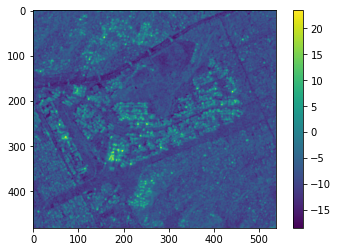

In [ ]:
plt.imshow(s1_np)
plt.colorbar()

(array([[  7., 139., 239., ...,   0.,   0.,   0.],
        [  4., 134., 248., ...,   0.,   0.,   0.],
        [  1., 104., 275., ...,   0.,   0.,   0.],
        ...,
        [  2., 117., 323., ...,   0.,   0.,   0.],
        [  0., 113., 320., ...,   0.,   0.,   0.],
        [  1., 100., 337., ...,   0.,   0.,   0.]]),
 array([-18.48356552, -14.29511133, -10.10665714,  -5.91820294,
         -1.72974875,   2.45870544,   6.64715963,  10.83561382,
         15.02406801,  19.21252221,  23.4009764 ]),
 <a list of 538 Lists of Patches objects>)

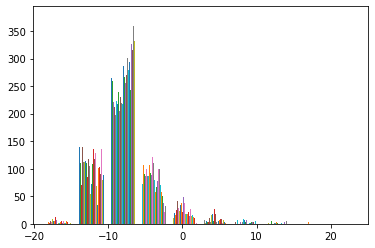

In [ ]:
plt.hist(s1_np)

In [ ]:
s2_np_swaped = np.swapaxes(s2_np,2,0)
s2_np_swaped = np.swapaxes(s2_np_swaped,1,0)
print(s2_np_swaped.shape)

(482, 538, 12)


In [ ]:
s2_np_oneband = s2_np_swaped[:,:,1]
print(np.min(s2_np_oneband),np.max(s2_np_oneband))
# s2_np_oneband = s2_np_oneband/np.max(s2_np_oneband)
# s2_np_oneband = s2_np_oneband * 255
# s2_np_oneband = s2_np_oneband.astype('uint8')

0.0425 0.8164


(482, 538)


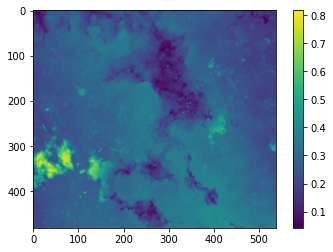

In [ ]:
print(s2_np_oneband.shape)
plt.imshow(s2_np_oneband)
plt.colorbar()

# Downlaod All!

In [15]:
import pandas as pd
import ast
import collections
import os
import shutil

In [16]:
rois_path = 'D:\python\TemporalGAN\dataset\\171921_ROIs.xlsx'

In [17]:
df = pd.read_excel(rois_path)

In [18]:
row = df.loc[0]
print(row['name']+str(row['year_type']))

abudhabi22


## checking if there is a duplicate in the names

In [19]:
names = []
for index, row in df.iterrows():
    names.append(row['name']+str(row['year_type']))

In [20]:
print([item for item, count in collections.Counter(names).items() if count > 1])

[]


## retriving every element

In [21]:
print(row['name']+str(row['year_type']))
print(ast.literal_eval(row['roi']))
print(row['date'])
print(row['priority_path'])
print(row['max_cloud'])
print(row['max_snow'])
print(row['month_span'])
print(row['retry_days'])
print(row['type'])

valencia_buffed22
[[[-0.486832, 39.351813], [-0.486832, 39.553816], [-0.300751, 39.553816], [-0.300751, 39.351813], [-0.486832, 39.351813]]]
('2021-06-07','2021-07-07')
DESCENDING
5
5
1
0
buff


In [22]:
# r_roi = ast.literal_eval(row['roi'])
# r_roi = ee.Geometry.Polygon(r_roi, None, False)

# r_pp =  row['priority_path']
# r_mc =  int(row['max_cloud'])
# r_ms =  int(row['max_snow'])
# r_ms =  int(row['month_span'])
# r_rd =  int(row['retry_days'])

# s2_col,s1_col = s1s2(r_roi , date = r_date , priority_path = r_pp , max_cloud =r_mc , max_snow = r_ms , month_span = r_ms ,retry_days = r_rd)

In [23]:
if not os.path.exists('/content/s1_imgs/'):
  os.mkdir('/content/s1_imgs/')
  os.mkdir('/content/s2_imgs/')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/s1_imgs/'

removing folders

In [ ]:
#shutil.rmtree('/content/s2_imgs/')  

In [25]:
sen2_short_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','roi_cloud_cover', 'CLOUDY_PIXEL_PERCENTAGE',
                                                                                                            'system:band_names'],
                                                             first_is_t_in_millis=True, df_instead_of_print=False)

sen1_short_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','platform_number',
                                                                                           'system:band_names','instrumentMode',                         
                                                                                            'relativeOrbitNumber_stop','relativeOrbitNumber_start',
                                                                                            'cycleNumber'],
                                                             first_is_t_in_millis=True, df_instead_of_print=False)

### dataset downlaoder

In [27]:

df = df.iloc[13:]

In [28]:
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
for index, row in df.iterrows():
    print("🟥🟥🟥",row['name']+str(row['year_type']),"🟥🟥🟥")
    r_roi = ast.literal_eval(row['roi'])
    r_roi = ee.Geometry.Polygon(r_roi, None, False)
    r_date = ast.literal_eval(row['date'])
    r_pp =  row['priority_path']
    r_mc =  int(row['max_cloud'])
    r_ms =  int(row['max_snow'])
    r_ms =  int(row['month_span'])
    r_rd =  int(row['retry_days'])

    s2_col,s1_col = s1s2(r_roi , date = r_date , priority_path = r_pp , max_cloud =r_mc , max_snow = r_ms , month_span = r_ms ,retry_days = r_rd)
    s1_col = s1_col.map(toLinear) # convers dB values to Linear, and adds band 'VV_lin' to the images of the collection
    sen2_short_print(s2_col)
    sen1_short_print(s1_col)
    #===============================================
    s1_img = s1_col.mean().clip(r_roi)
    s1_img = toDb(s1_img) # reads the 'VV_lin' and returns the image with the added band 'VV_db' 
    s2_img = s2_col.median().clip(r_roi).multiply(0.0001)

    s1_img_vv = s1_img.select('VV_db')
    s2_img_12b = s2_img.select(bands)
    
    r_name = str(index+1).zfill(3) + '_' + row['name'] + str(row['year_type'])
#     geemap.download_ee_image(s1_img_vv, '/content/s1_imgs/'+r_name+".tif",crs='EPSG:4326', scale=10,region = r_roi)
#     geemap.download_ee_image(s2_img_12b, '/content/s2_imgs/'+r_name+".tif",crs='EPSG:4326', scale=10,region = r_roi)

🟥🟥🟥 brasilia_buffed22 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2021-06-24
final date range:  2021-05-24 2021-07-24
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 98.68002743532315 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
collection size before removing snowy dates:  5
collection size after removing snowy dates:  5
◍Collection Found!
system:time_start-------> ['2021-06-08', '2021-06-13', '2021-06-16', '2021-06-21', '2021-06-23', '2021-06-26', '2021-06-28', '2021-07-01', '2021-07-03', '2021-07-06']
roi_cloud_cover---------> [0.05822807489026247, 3.229169777140753, 2.4507217958799075, 0.5744838271936722, 0, 0, 2.8216561988845426, 0, 0, 0]
CLOUDY_PIXEL_PERCENTAGE-> [1.029541, 5.045863, 2.124389, 1.66795, 0.048593, 0.11095, 3.777802, 0.087004, 0.060185, 0.104731]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP',

In [ ]:
! du -sh /content/s1_imgs/
! du -sh /content/s2_imgs/

4.0K	/content/s1_imgs/
4.0K	/content/s2_imgs/


# Translate Js to Python

In [ ]:
js_snippet = """
function toLinear(db) {
  return db.addBands(
    ee.Image().expression('pow(10, db / 10)', {
      db: db.select(['VV', 'VH'])
    }),
    null, true // Replace the bands to keep image properties
  )
}
"""

lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()

def toLinear(db):
  return db.addBands(
    ee.Image().expression('pow(10, db / 10)', {
      'db': db.select(['VV', 'VH'])
    }),
    None, True # Replace the bands to keep image properties
  )

Map


In [ ]:
print('hello')

hello


## Saving downloaded dataset for later use in drive

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/s1_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1")
# copy_tree("/content/s2_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2")

# patching the files

## importing patch function
`perfect_patchify` is what I worte on my own.

we also install and import `patchify` library

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/rgb2sar/pyModules/')
from patch_perfect import perfect_patchify

In [ ]:
from patchify import patchify

##loading the data from drive to working directory

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1","/content/s1_imgs")
copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2","/content/s2_imgs")

KeyboardInterrupt: ignored

In [ ]:
from skimage import io

## patchify s2 images

In [ ]:
geo_context = {
    'abudhabi':1,
    'dubai':1,
    'aguasclaras':2,
    'brasilia':2,
    'bercy':3,
    'paris':3,
    'saclay_e':3,
    'saclay_w':3,
    'bordeaux':4,
    'nantes':5,
    'rennes':6,
    'montpellier':7,
    'pisa':8,
    'norcia':9,
    'milano':10,
    'valencia':11,
    'chongqing':12,
    'beihai':13,
    'hongkong':14,
    'cupertino':15,
    'lasvegas':16,
    'beirut':17,
    'rio':18,
    'mumbai':19
}

In [ ]:
def add_geo_context(img,img_name:str,geo_dict:dict, norm_factor=20):
    for key in  geo_dict.keys():
        if key in img_name:
            print('matched ', key)
            const_layer = np.ones((img.shape[0],img.shape[1],1)) * (geo_dict[key]/norm_factor)
            #print(const_layer)
            stack_img = np.dstack([img,const_layer])
            break
    else:
        raise('❗️No key matched the name!❗️')
    return stack_img

In [ ]:
# shutil.rmtree('/content/s2_imgs_patched//')

In [ ]:
def shape_correction(image):
  """
  fixing the image dimentions, for some wierd reason, in.imread() 
  reads images with more than 3 (sometimes 4!) channels in a reverse order like: (12, 1325, 3345) instead of (1325, 3345,12)
  so we fist check if the image is multy channel, if it is multichanenl, then we check if shape[0] is les than shape[2], and since in
  our case dimenstion of images are always bigger than number of channels, if this condition is not true, it means that the shape
  is in reverse order, so we swap the axis to fix this issue.
  """
  x = image
  print(x.shape)
  if (len(x.shape)==3):
      if x.shape[0]<x.shape[2] :
          z = np.swapaxes(x, 2,0)
          img = np.swapaxes(z, 1,0)
      else:
          img = x
  else:
      img = np.expand_dims(x,axis=2)
  return img

In [ ]:
def nan_remover(image,nan_threshhold = 1):
  """
  Inputs
  ---
  `image`: a nd numpy array
  `nan_threshhold`: the precentaage of nans that is acceptable
  """
  nan_ratio = (np.count_nonzero(np.isnan(image))/image.size) * 100
  print(f'NaN Ratio: {nan_ratio} Percent')
  if nan_ratio > nan_threshhold:
    print(f'⚠️ High NaN ratio! ⚠️')

  image[np.isnan(image)] = 0.01
  return image

In [ ]:
if not os.path.exists('/content/s1s2'):
  os.mkdir('/content/s1s2')

In [ ]:
if not os.path.exists('/content/s1s2/s1_imgs_patched//'):
  os.mkdir('/content/s1s2/s1_imgs_patched//')
if not os.path.exists('/content/s1s2/s2_imgs_patched//'):
  os.mkdir('/content/s1s2/s2_imgs_patched//')

In [ ]:
path = '/content/s2_imgs//'
opath = '/content/s1s2/s2_imgs_patched//'
files = os.listdir(path)
files.sort()

for file in files:
    print('📍📍📍🗺️ \033[92m', file ,'\033[0m 🗺️📍📍📍')
    x=io.imread(path+file)
    img = shape_correction(x)
    print(img.shape)



    print("range before norm: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    print(img.shape) #sanity check to see if masks are the same size as images
    
    img = add_geo_context(img,file,geo_context)

    

    img[img>0.99] = 0.99
    img[img<0] = 0
    img = nan_remover(img)

    print("range after norm and NaN removal: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    if ('adj' in file) or ('buffed' in file):
      print('🟥not main')
      patches = perfect_patchify(img,mute=True)
    else:
      print('🟦main')
      patches = patchify(img,(256,256,13),step=128)
      patches = patches[:,:,0,:,:,:]
    
    print('✅',patches.shape)

    # SAVING PATHCES
    img_index = file[0:3]
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:,:]
            #print(patch.shape)
            patch = np.swapaxes(patch, 2,0)
            patch= np.swapaxes(patch, 1,2)
            
            io.imsave(opath +img_index+ '_r'+ str(i).zfill(2) + '_c' + str(j).zfill(2) + '.tif', patch)

## checking the NaN ratio

In [ ]:
! du -sh /content/s1s2/s2_imgs_patched//

In [ ]:
patched_s2 = os.listdir('/content/s1s2/s2_imgs_patched//')
print(len(patched_s2))

In [ ]:
# s2_test = io.imread('/content/s2_imgs/013_beirut20.tif')

# p=s2_test
# print(p.shape)
# if (len(p.shape)==3):
#     if p.shape[0]<p.shape[2] :
#         q = np.swapaxes(p, 2,0)
#         s2_test = np.swapaxes(q, 1,0)
#     else:
#         s2_test = p
# else:
#     s2_test = np.expand_dims(p,axis=2)


# print(s2_test.shape)

# print(np.min(s2_test),np.mean(s2_test),np.max(s2_test))
# print(np.count_nonzero(np.isnan(s2_test)))
# s2_test[np.isnan(s2_test)] = 0
# print(np.min(s2_test),np.mean(s2_test),np.max(s2_test))
# # s2_test[np.isnan(s2_test)] = 100
# # s2_test[~np.isnan(s2_test)] = 0
# plt.imshow(s2_test[:,:,[3,2,1]])
# plt.colorbar()


In [ ]:
path = '/content/s1_imgs//'
opath = '/content/s1s2/s1_imgs_patched//'
files = os.listdir(path)
files.sort()

for file in files:
    print('📍📍📍🗺️ \033[92m', file ,'\033[0m 🗺️📍📍📍')
    x=io.imread(path+file)
    img = shape_correction(x)
    print(img.shape)



    print("range before norm: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    print(img.shape) #sanity check to see if masks are the same size as images
    
    #img = add_geo_context(img,file,geo_context)

    

    img[img>15] = 15
    img[img<-25] = -25
    img = nan_remover(img)

    print("range after norm and NaN removal: ",np.min(img),'\033[96m',np.mean(img),np.std(img),'\033[0m',np.max(img))

    if ('adj' in file) or ('buffed' in file):
      print('🟥not main')
      patches = perfect_patchify(img,mute=True)
    else:
      print('🟦main')
      patches = patchify(img,(256,256,1),step=128)
      patches = patches[:,:,0,:,:,:]
    
    print('✅',patches.shape)

    # SAVING PATHCES
    img_index = file[0:3]
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:,:]
            #print(patch.shape)
            # patch = np.swapaxes(patch, 2,0)
            # patch= np.swapaxes(patch, 1,2)
            
            io.imsave(opath +img_index+ '_r'+ str(i).zfill(2) + '_c' + str(j).zfill(2) + '.tif', patch)

## checking if the dimentions are  correct

In [ ]:
x=io.imread('/content/s1s2/s1_imgs_patched/000_r00_c01.tif')
# img = shape_correction(x)
print(x.shape)
plt.imshow(x[:,:,0])
# plt.imshow(x[3,:,:])

In [ ]:
x=io.imread('/content/s1s2/s2_imgs_patched/000_r00_c01.tif')
# img = shape_correction(x)
print(x.shape)
# plt.imshow(x[:,:,0])
plt.imshow(x[2,:,:])

In [ ]:
! du -sh /content/s1s2/s1_imgs_patched//

In [ ]:
patched_s1 = os.listdir('/content/s1s2/s1_imgs_patched//')
print(len(patched_s1))

## converting the patched folders into zip files

In [ ]:
!zip -r '/content/s1s2.zip' '/content/s1s2'

In [ ]:
! du -sh /content/s1s2.zip

In [ ]:
# from IPython.display import FileLink
# FileLink(r's1s2.zip')

In [ ]:
!cp "/content/s1s2.zip" "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/"